In [1]:
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)


/Users/davidangeles/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# Load DataFrame
df = pd.read_csv('../input/singer_transcript_counts.csv',
                comment='#')

# Take a look
df.head()


,Rex1,Rest,Nanog,Prdm14
0,11,34,39,0
1,172,91,33,5
2,261,70,68,0
3,178,54,88,1
4,129,54,41,0


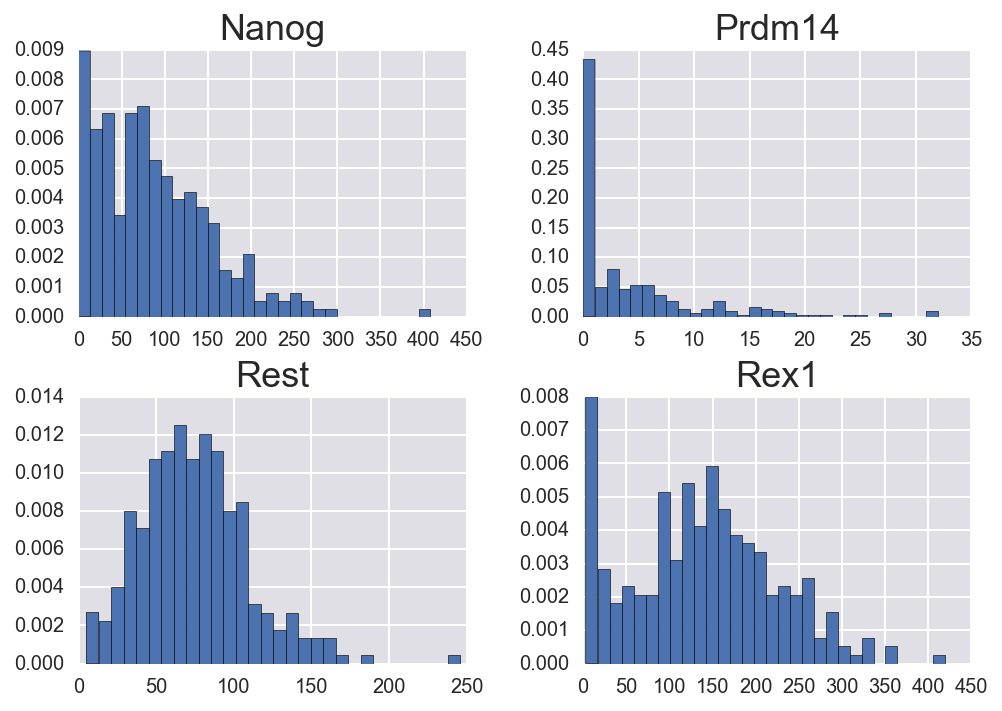

In [5]:
_ = df.hist(normed=True, bins=30)

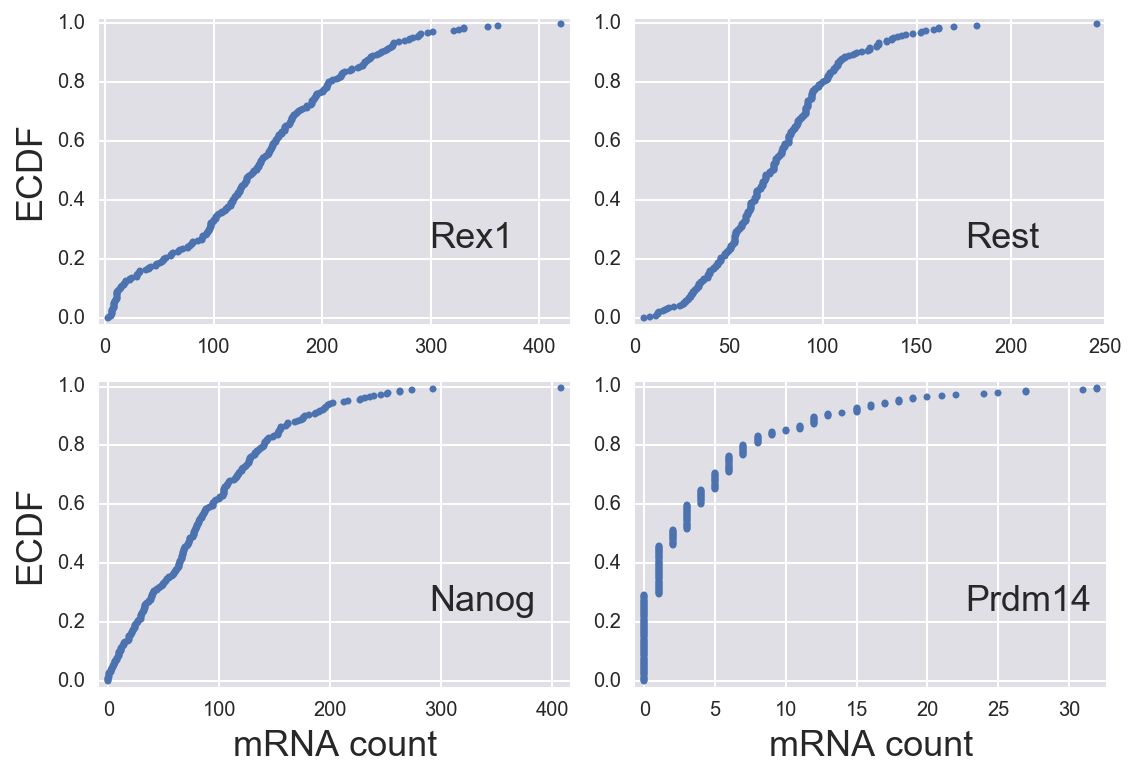

In [6]:
#plot ecdfs

fig, ax= plt.subplots(2,2)

#below makes all possible tuples of (0, 1)*(0,1)
sp_inds= list(itertools.product([0, 1], [0,1]))

for i, gene in enumerate(df.columns):
    
    
    y= np.arange(len(df[gene]))/len(df[gene])
    x= np.sort(df[gene].values)
    
    #plot
    ax[sp_inds[i]].plot(x, y, '.')
    ax[sp_inds[i]].text(0.7, 0.25, gene, \
                        transform= ax[sp_inds[i]].transAxes, fontsize= 18)
    ax[sp_inds[i]].margins(0.02)
    
#clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('ECDF')
plt.tight_layout()

In [25]:
def log_posterior(params, n):
    """
    Log posterior for MLE of Singer data
    """
    
    r, p= params
    
    #zero probability of p <0 or p>1
    if p<0 or p>1:
        return -np.inf
    
    #zero probability of burst parameter r being less than o
    if r < 0:
        return -np.inf
    
    return st.nbinom.logpmf(n, r, p).sum()

    
def neg_log_posterior(params, n):
    """
    Negative log posterior for MLE of Singer data.
    """
    return -log_posterior(params, n)


In [26]:
#guess:
p0= np.array([5, .5])

#define hessian with small step size to avoid discontinuity
hes_fun= ndt.Hessian(log_posterior, step= 0.001)

df_MAP= pd.DataFrame(columns= ['gene', 'r', 'r_err', 'p', 'p_err', 'b'])

#mle
for i, gene in enumerate(df.columns):
    #minimize!
    res = scipy.optimize.minimize(neg_log_posterior, p0, args=(df[gene],), 
                                  method='powell')
    
    #error bars
    hes= hes_fun(res.x, df[gene])
    cov= -np.linalg.inv(hes)
    
    #unpack 
    df_out = pd.DataFrame([[gene, 
                            res.x[0], 
                            np.sqrt(cov[0,0]), 
                            res.x[1], 
                            np.sqrt(cov[1,1]), 
                            (1 - res.x[1]) / res.x[1]]],
                          columns=df_MAP.columns, index=[i])
    df_MAP= df_MAP.append(df_out)
    
df_MAP

,gene,r,r_err,p,p_err,b
0,Rex1,1.632727,0.128773,0.011662,0.001047,84.745111
1,Rest,4.529541,0.399467,0.057003,0.004988,16.542935
2,Nanog,1.263356,0.101061,0.014195,0.001338,69.446285
3,Prdm14,0.552853,0.057854,0.108689,0.013077,8.200553


In [27]:
def log_posterior_bimodal(params, n):
    """
    Log of posterior for lin comb of neg. binomials
    """
    r_1, r_2, p_1, p_2, f= params
    
    if (f<0) or (f>1):
        return -np.inf
    
    if (r_1 < 0) or (r_2 < 0) or (p_1 < p_2) or (p_2 < 0) or (p_1 > 1):
        return -np.inf
    
    return np.log(f*st.nbinom.pmf(n, r_1, p_1)\
           + (1-f)*st.nbinom.pmf(n, r_2, p_2)).sum()

def neg_log_posterior_bimodal(params, n):
    """
    Neg. log posterior for lin comb of neg binom
    """
    return -log_posterior_bimodal(params, n)
    

In [102]:
# Give inital guesses
p0 = np.array([5, 5, 0.3, 0.1, 0.5])

# Define Hessian function with small initial step size to avoid discontinuity
hes_fun = ndt.Hessian(log_posterior_bimodal, step= 0.0001)

# Perform the optimization
res = scipy.optimize.minimize(neg_log_posterior_bimodal, p0, 
                              args=(df['Rex1'],), method='powell')

# Compute error bars
hes = hes_fun(res.x, df['Rex1'])
cov = -np.linalg.inv(hes)

# Store results in DataFrame
columns = ['r1', 'r1_err', 'r2', 'r2_err', 
           'p1', 'p1_err', 'p2', 'p2_err', 
           'f', 'f_err', 'b1', 'b2']

#the one-liner below is super smart!
data = [x[j] for x in list(zip(res.x, np.sqrt(np.diag(cov)))) 
             for j in range(len(x))]

data += [(1 - res.x[2]) / res.x[2], (1 - res.x[3]) / res.x[3]]

df_Rex1_bimodal = pd.DataFrame([data], columns=columns)

# Have a look
df_Rex1_bimodal

,r1,r1_err,r2,r2_err,p1,p1_err,p2,p2_err,f,f_err,b1,b2
0,3.065635,1.141327,5.163311,0.687201,0.170447,0.070752,0.030843,0.003817,0.159909,0.025861,4.866927,31.422723


/Users/davidangeles/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/davidangeles/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


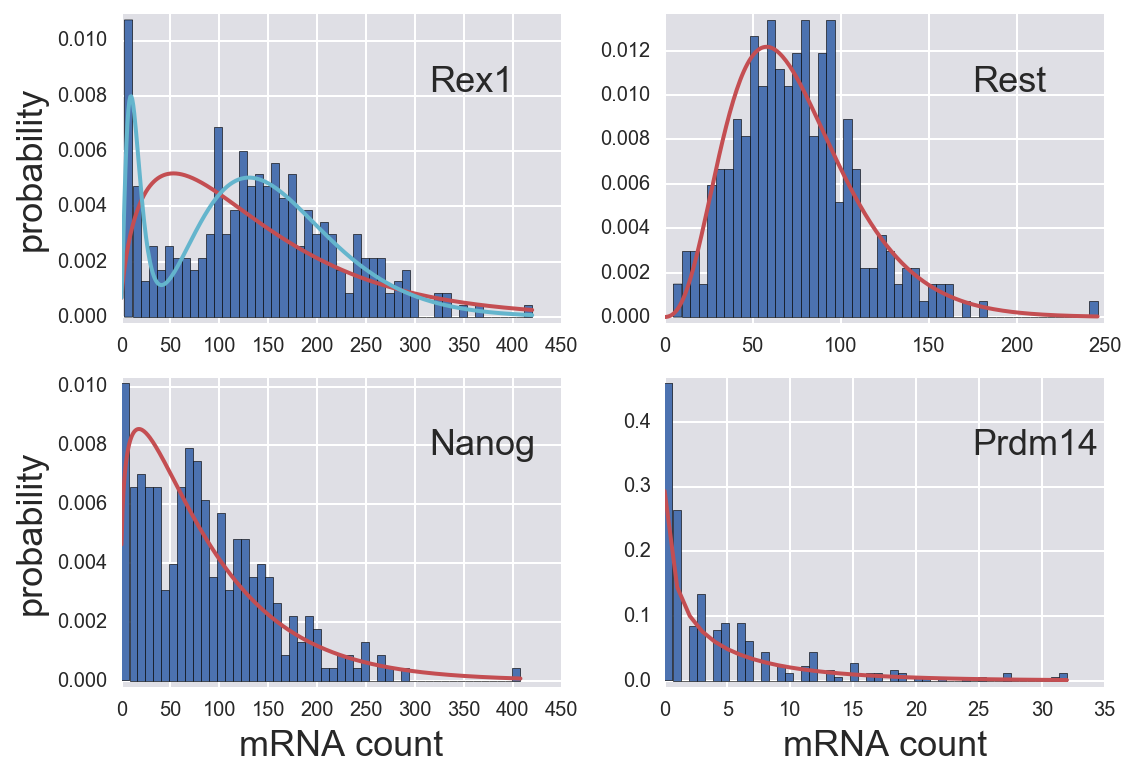

In [103]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # What data to take from MAP DataFrame
    inds = (df_MAP['gene']==gene)
    
    # Build theroetical PMF
    n_plot = np.arange(0, df[gene].max()+1)
    r, p = df_MAP[inds][['r', 'p']].values.flatten()

    # Plot histogram and PMF
    _ = ax[sp_inds[i]].hist(df[gene], bins=50, normed=True)
    ax[sp_inds[i]].plot(n_plot, st.nbinom.pmf(n_plot, r, p), '-', 
                        color=sns.color_palette()[2])
    
    # If it's Rex1, also show the bimodal PMF
    if gene == 'Rex1':
        # Build theroetical PMF
        cols = ['r1', 'r2', 'p1', 'p2', 'f']
        r_1, r_2, p_1, p_2, f = df_Rex1_bimodal[inds][cols].values.flatten()
        pmf = f * st.nbinom.pmf(n_plot,r_1, p_1) +\
                (1-f) * st.nbinom.pmf(n_plot,r_2, p_2)
        ax[sp_inds[i]].plot(n_plot, pmf, '-', color=sns.color_palette()[5])

    # Clean up plot
    ax[sp_inds[i]].text(0.7, 0.75, gene, transform=ax[sp_inds[i]].transAxes,
                        fontsize=18)
    ax[sp_inds[i]].margins(y=0.02)

# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('probability')
plt.tight_layout()


/Users/davidangeles/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/davidangeles/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


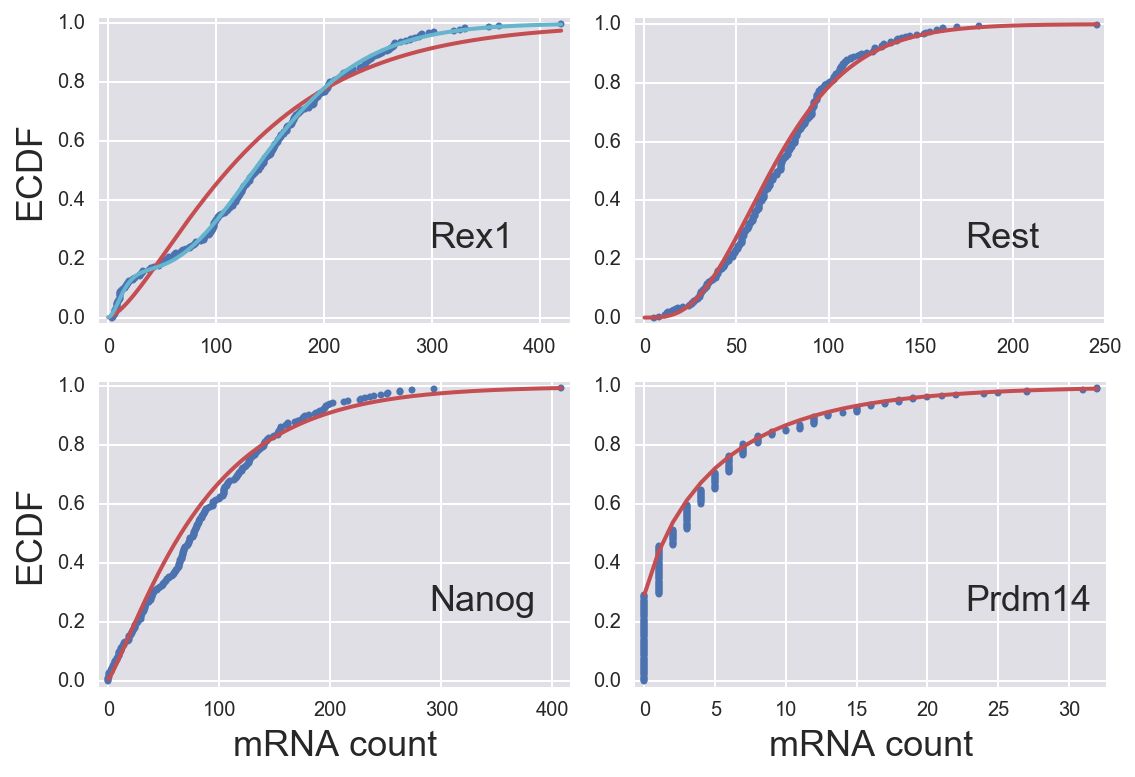

In [104]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # What data to take from MAP DataFrame
    inds = (df_MAP['gene']==gene)
    
    # Build ECDF
    y = np.arange(len(df[gene])) / len(df[gene])
    x = np.sort(df[gene].values)
    
    # Plot
    ax[sp_inds[i]].plot(x, y, '.')
    ax[sp_inds[i]].text(0.7, 0.25, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=18)
    ax[sp_inds[i]].margins(0.02)
    
    # Overlay theoretical CDF
    n_plot = np.arange(0, df[gene].max()+1)
    r, p = df_MAP[inds][['r', 'p']].values.flatten()
    ax[sp_inds[i]].plot(n_plot, st.nbinom.cdf(n_plot, r, p), '-',
                        color=sns.color_palette()[2])
    
    # If it is Rex1, do bimodal as well
    if gene == 'Rex1':
        # Build theroetical PMF
        cols = ['r1', 'r2', 'p1', 'p2', 'f']
        r_1, r_2, p_1, p_2, f = df_Rex1_bimodal[inds][cols].values.flatten()
        cdf = f * st.nbinom.cdf(n_plot,r_1, p_1) +\
                (1-f) * st.nbinom.cdf(n_plot,r_2, p_2)
        ax[sp_inds[i]].plot(n_plot, cdf, '-', color=sns.color_palette()[5])
    
# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('ECDF')
plt.tight_layout()


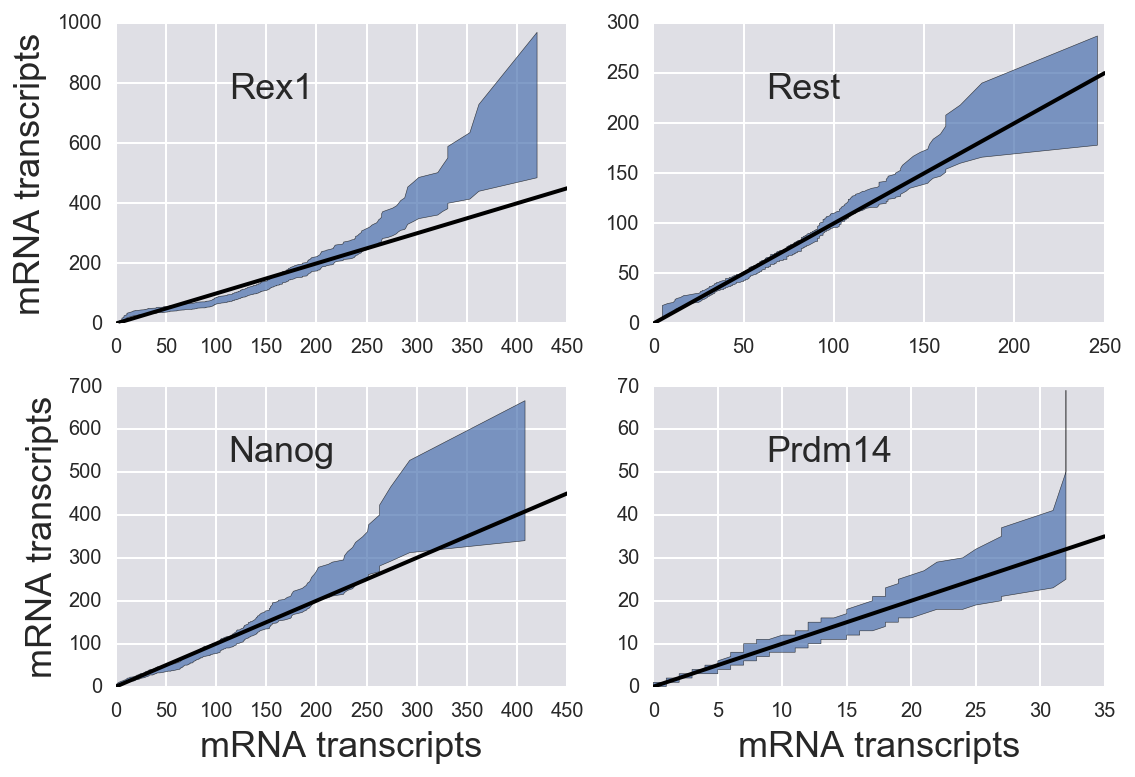

In [105]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # What data to take from MAP DataFrame
    inds = (df_MAP['gene']==gene)

    # Parameters
    r, p = df_MAP[inds][['r', 'p']].values.flatten()

    # x-values
    x = np.sort(df[gene].values)
    
    # Make draws
    theor_x = np.array(
        [np.sort(st.nbinom.rvs(r, p, size=len(x))) for _ in range(1000)])

    # Upper and lower bounds
    low_theor, up_theor = np.percentile(theor_x, (2.5, 97.5), axis=0)

    # Plot Q-Q plots with 95% conf.
    ax[sp_inds[i]].fill_between(x, up_theor, low_theor, alpha=0.7)
    
    # Plot 45 degree line
    x_lim = ax[sp_inds[i]].get_xlim()
    ax[sp_inds[i]].plot(x_lim, x_lim, 'k-')
    
    # Label plot
    ax[sp_inds[i]].text(0.25, 0.75, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=18)

# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA transcripts')
    ax[i,0].set_ylabel('mRNA transcripts')
plt.tight_layout()


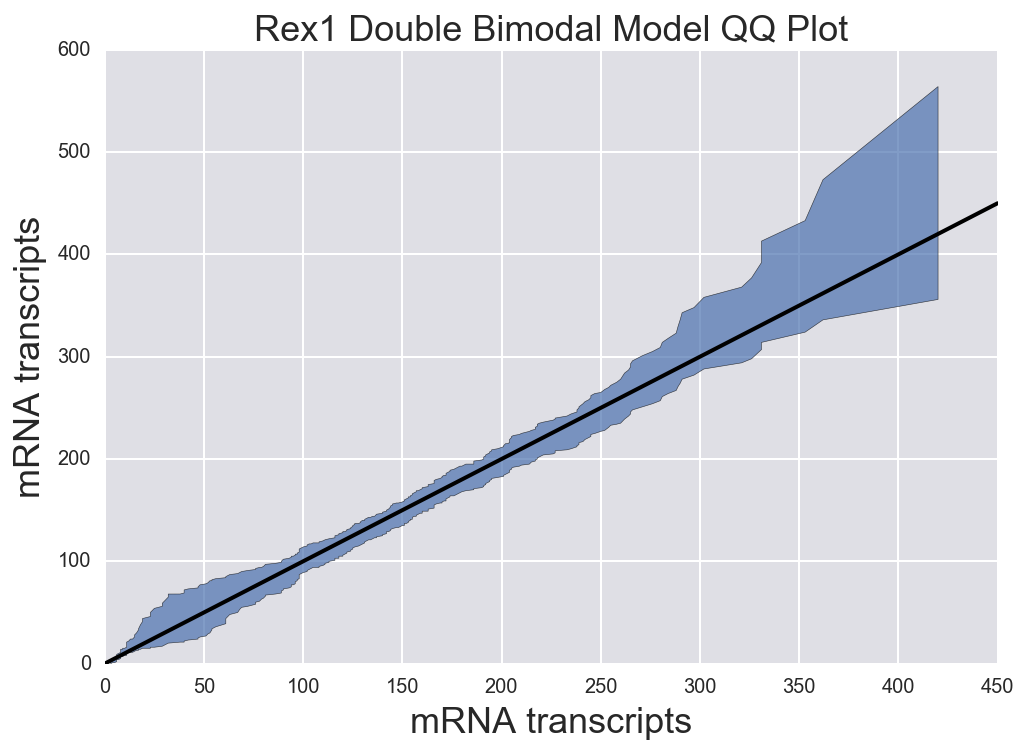

In [106]:
# Pull out parameters
cols = ['r1', 'r2', 'p1', 'p2', 'f']
r1, r2, p1, p2, f = df_Rex1_bimodal[cols].values.flatten()

# x-values
x = np.sort(df['Rex1'].values)

# Make draws
def draw_double_neg_binom(r1, r2, p1, p2, f, size=1):
    """
    Draw from double negative binomial
    """
    fr = st.bernoulli.rvs(f, size=size)
    return fr * st.nbinom.rvs(r1, p1, size=size) + \
            (1-fr) * st.nbinom.rvs(r2, p2, size=size)
    
    
theor_x = np.array(
    [np.sort(draw_double_neg_binom(r1, r2, p1, p2, f, size=len(x)))
                     for _ in range(1000)])

# Upper and lower bounds
low_theor, up_theor = np.percentile(theor_x, (2.5, 97.5), axis=0)

# Plot Q-Q plots with 95% conf.
plt.fill_between(x, up_theor, low_theor, alpha=0.7)

# Plot 45 degree line
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, x_lim, 'k-')

# Label axes
plt.xlabel('mRNA transcripts')
plt.ylabel('mRNA transcripts')
plt.title('Rex1 Double Bimodal Model QQ Plot')